In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
from qutip import *
from qutip.qip.circuit import gate_sequence_product, QubitCircuit

qutip.settings.has_mkl = False  # Fix the OS erros in VSCode

from sync_plots import *
from sync_calcs import *
from sync_gates import *


# Gain & Loss Test

In [22]:
STEPS = 80
gain_amp = 1
loss_amp = 0.1
m = min(loss_amp, gain_amp)

detuning = 3 * m
signal_strength = 2 * m
dt = 0.5

theta_d = 2 * np.arcsin(np.sqrt(loss_amp * dt))
theta_g = 2 * np.arcsin(np.sqrt(gain_amp * dt))

In [23]:
from functools import lru_cache
@lru_cache(maxsize=None)
def discrete_simulation(detuning, signal_strength, dt, theta_d, theta_g, steps):
    unit_evo_qc = unitary_circuit(detuning, signal_strength, dt)
    loss_qc, gain_qc = dissipative_circuits(theta_d, theta_g)

    initial_state = tensor(ket2dm(basis(2, 0)), ket2dm(basis(2, 0)))

    states = []

    start_state = initial_state
    for _ in range(steps):
        result = unit_evo_qc.run(state=start_state)

        result = loss_qc.run(state=tensor(result.ptrace(0), ket2dm(basis(2, 0))))  # & Reset
        # result = gain_qc.run(state=tensor(result.ptrace(0), ket2dm(basis(2, 0))))  # & Reset

        state = result.ptrace(0)

        start_state = tensor(state, ket2dm(basis(2, 0)))  # Reset
        states.append(state)
    
    return states


In [24]:
states = discrete_simulation(detuning, signal_strength, dt, theta_d, theta_g, steps=STEPS)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.90878316+0.j         -0.07061108-0.26285948j]
 [-0.07061108+0.26285948j  0.09121684+0.j        ]]

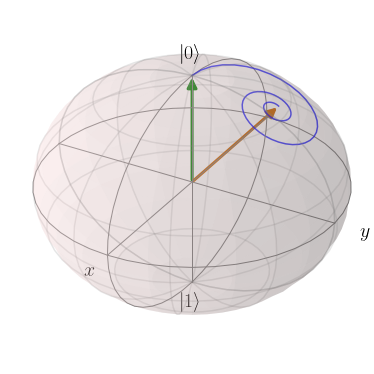

In [25]:
# Plot Bloch sphere rep of states
b = Bloch()

b.add_states(basis(2, 0))

points = dm2bloch([[[1, 0], [0, 0]], *states])
b.add_points(points, meth="l") # Find a point with a good aproximation of the steady state 
b.add_states(states[-1])

b.show()

states[-1]

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.90878316+0.j         -0.07061108-0.26285948j]
 [-0.07061108+0.26285948j  0.09121684+0.j        ]]

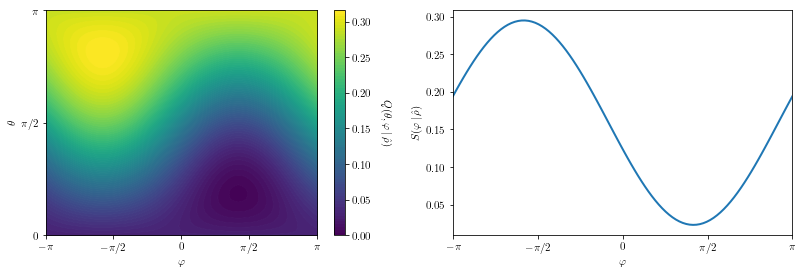

In [26]:
ss = states[-1]
fig, axs = calc_and_plot_Q_and_S(ss, method="qutip")
ss

In [27]:
fig.savefig('q-func-sync-measure.pdf', bbox_inches="tight")

# Detuning $\times$ Phase $\times$ $S$

In [28]:
STEPS = 50
dt = 1

n = 40
DR = 1
detunings = np.linspace(-DR, DR, n)

Gamma_g = 1
Gamma_d = 0.1
theta_d = 2*np.arcsin(np.sqrt(loss_amp * dt))
theta_g = 2*np.arcsin(np.sqrt(gain_amp * dt))

m = 20
theta = np.linspace(0, np.pi, m)
phi = np.linspace(-np.pi, np.pi, 2 * m).reshape(-1, 1)

S = np.zeros([2*m, n])

for i, D in enumerate(detunings):
    states = discrete_simulation(D, Gamma_d, dt, theta_d, theta_g, steps=STEPS)
    s = states[-1].full()
    # s[0,0], s[1,1] = s[1,1], s[0,0]
    # s[0,1], s[1,0] = s[1,0], s[0,1]
    state = Qobj(s)
    Q = spin_husimi_qfunc(state, theta, phi)
    s = spin_S_measure(theta, Q)

    S[:, i] = s

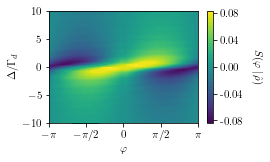

In [29]:
fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH / 2))

DETUNING, PHI = np.meshgrid(detunings / loss_amp, phi)

cquad = ax.contourf(PHI, DETUNING, np.concatenate([S[20:, :], S[:20, :]]), 100)
for c in cquad.collections:
    c.set_edgecolor("face")
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\Delta/\Gamma_d$')

cbar = fig.colorbar(cquad)
cbar.set_label(r"$S(\varphi\,|\,\hat\rho)$", rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_locator(MultipleLocator(base=0.04))
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
angle_xaxis(ax)

fig.savefig('results/dsims/vary-detuning.pdf', bbox_inches="tight")

# Strength $\times$ Phase $\times$ $S$

In [30]:
STEPS = 50
dt = 1

n = 40
ER = 0.1
strengths = np.linspace(0, ER, n)

Gamma_g = 1
Gamma_d = 0.1
theta_d = 2*np.arcsin(np.sqrt(loss_amp * dt))
theta_g = 2*np.arcsin(np.sqrt(gain_amp * dt))

m = 20
theta = np.linspace(0, np.pi, m)
phi = np.linspace(-np.pi, np.pi, 2 * m).reshape(-1, 1)

S = np.zeros([2*m, n])

for i, E in enumerate(strengths):
    states = discrete_simulation(0, E, dt, theta_d, theta_g, steps=STEPS)
    s = states[-1].full()
    s[0,0], s[1,1] = s[1,1], s[0,0]
    s[0,1], s[1,0] = s[1,0], s[0,1]
    state = Qobj(s)
    Q = spin_husimi_qfunc(state, theta, phi)
    s = spin_S_measure(theta, Q)

    S[:, i] = s

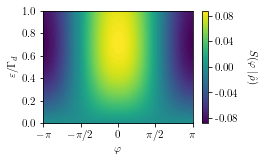

In [31]:
fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH / 2))

STRENGTHS, PHI = np.meshgrid(strengths / loss_amp, phi)



cquad = ax.contourf(PHI, STRENGTHS, np.concatenate([S[20:, :], S[:20, :]], axis=0), 100)
for c in cquad.collections:
    c.set_edgecolor("face")
ax.set_xlabel(r'$\varphi$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

cbar = fig.colorbar(cquad)
cbar.set_label(r"$S(\varphi\,|\,\hat\rho)$", rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_locator(MultipleLocator(base=0.04))
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))
angle_xaxis(ax)

fig.savefig('results/dsims/vary-strength.pdf', bbox_inches="tight")

# Arnold Tongue

In [34]:
STEPS = 50
n = 20
Gamma_g = 0.1
Gamma_d = 1
theta_d = 2*np.arcsin(np.sqrt(Gamma_d * dt))
theta_g = 2*np.arcsin(np.sqrt(Gamma_g * dt))

Smax = np.zeros([2 * n, n])

DR = 1
detunings = np.linspace(-DR, DR, 2*n)

ER = 1
strengths = np.linspace(0, ER, n)

m = 50
theta = np.linspace(0, np.pi, m)
phi = np.linspace(-np.pi, np.pi, 2 * m).reshape(-1, 1)

for i, D in enumerate(detunings):
    for j, E in enumerate(strengths):
        states = discrete_simulation(D, E, dt, theta_d, theta_g, steps=STEPS)
        state = states[-1].full()

        # Swap around dm parts to give correct orientation
        # s[0, 0], s[1, 1] = s[1, 1], s[0, 0]
        # s[0, 1], s[1, 0] = s[1, 0], s[0, 1]
        Q = spin_husimi_qfunc(state, theta, phi)
        S = spin_S_measure(theta, Q)

        Smax[i, j] = np.max(S)

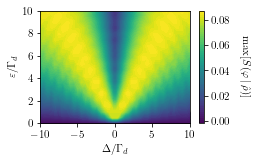

In [35]:
fig, ax = plt.subplots(figsize=set_size(DOCUMENT_WIDTH / 2))

DETUNINGS, STRENGTHS  = np.meshgrid(detunings / loss_amp, strengths / loss_amp)

cquad = ax.contourf(DETUNINGS, STRENGTHS, Smax.T, 80)
for c in cquad.collections:
    c.set_edgecolor("face")
ax.set_xlabel(r'$\Delta/\Gamma_d$')
ax.set_ylabel(r'$\varepsilon/\Gamma_d$')

cbar = fig.colorbar(cquad)

cbar.set_label(r"$\max[S(\varphi\,|\,\hat\rho)]$", rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_locator(MultipleLocator(base=0.02))
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"{v:.2f}"))

fig.savefig('results/dsims/discrete-arnold-tongue.pdf', bbox_inches="tight")